## 샘플 데이터셋 로드

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import load_boston
import torch

warnings.filterwarnings('ignore')

In [2]:
# sklearn.datasets 내장 데이터셋인 보스톤 주택 가격 데이터셋 로드
data = load_boston()

**컬럼 소개**

속성 수 : 13

* **CRIM**: 자치시 별 범죄율
* **ZN**: 25,000 평방 피트를 초과하는 주거용 토지의 비율
* **INDUS**: 비소매(non-retail) 비즈니스 토지 비율
* **CHAS**: 찰스 강과 인접한 경우에 대한 더비 변수 (1= 인접, 0= 인접하지 않음)
* **NOX**: 산화 질소 농도 (10ppm)
* **RM**:주택당 평균 객실 수
* **AGE**: 1940 년 이전에 건축된 자가소유 점유 비율
* **DIS**: 5 개의 보스턴 고용 센터까지의 가중 거리     
* **RAD**: 고속도로 접근성 지수
* **TAX**: 10,000 달러 당 전체 가치 재산 세율
* **PTRATIO**  도시별 학생-교사 비율
* **B**: 인구당 흑인의 비율. 1000(Bk - 0.63)^2, (Bk는 흑인의 비율을 뜻함)
* **LSTAT**: 하위 계층의 비율
* **target**: 자가 주택의 중앙값 (1,000 달러 단위)

In [3]:
# 데이터프레임 생성. 504개의 행. Feature: 13개, target은 예측 변수(주택가격)
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['target'] = data['target']
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
# feature 변수의 개수 지정
NUM_FEATURES = len(df.drop('target', 1).columns)
print(f'number of features: {NUM_FEATURES}')

number of features: 13


## 서브클래싱으로 CustomDataset 생성

- SubClassing으로 Dataset을 상속받아 구현하게 되면 DataLoader에 주입하여 배치(batch) 구성을 쉽게 할 수 있습니다.
- 보통 `__init__()` 함수에서 데이터를 set 해주게 되고, 기타 필요한 전처리를 수행합니다. Image Transformation은 `__getitem__(self, idx)`에서 구현하는 경우도 있습니다.
- SubClassing으로 커스텀 Dataset을 구성한다면 `__len__(self)`함수와 `__getitem__(self, idx)`를 구현해야 합니다.
- [참고: 파이토치 튜토리얼(Tutorials > Dataset과 DataLoader)](https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html)

In [5]:
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

class CustomDataset(Dataset):
    def __init__(self, data, target='target', normalize=True):
        super(CustomDataset, self).__init__()
        self.x = data.drop(target, 1)
        
        # 데이터 표준화
        if normalize:
            scaler = StandardScaler()
            self.x = pd.DataFrame(scaler.fit_transform(self.x))
        
        self.y = data['target']
        
        # 텐서 변환
        self.x = torch.tensor(self.x.values).float()
        self.y = torch.tensor(self.y).float()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

In [6]:
# Custom으로 정의한 데이터셋 생성
dataset = CustomDataset(df, 'target', True)

Custom으로 정의한 데이터셋은 `torch.utils.data.DataLoader`에 주입할 수 있습니다.

In [62]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, 
                         batch_size=32, 
                         shuffle=True)

In [63]:
x, y = next(iter(data_loader))

In [64]:
x.shape, y.shape

(torch.Size([32, 13]), torch.Size([32]))

## PyTorch를 활용하여 회귀(regression) 예측

In [10]:
# Device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 32)
        self.fc2 = nn.Linear(32, 8)
        # 마지막 출력층의 Neuron은 1개로 설정
        self.output = nn.Linear(8, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [56]:
# 모델 생성
model = Net(NUM_FEATURES)
# 모델을 device 에 올립니다. (cuda:0 혹은 cpu)
model.to(device)
model

Net(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

## 손실함수(Loss Function) / 옵티마이저(Optimzier) 정의

In [57]:
# Mean Squared Error(MSE) 오차 정의
loss_fn = nn.MSELoss()

In [61]:
# 옵티마이저 설정: model.paramters()와 learning_rate 설정
optimizer = optim.Adam(model.parameters(), lr=0.005)

## 경사하강법을 활용한 회귀 예측

In [59]:
# 최대 반복 횟수 정의
num_epoch = 200

# loss 기록하기 위한 list 정의
losses = []

for epoch in range(num_epoch):
    # loss 초기화
    running_loss = 0
    for x, y in data_loader:
        # x, y 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
        x = x.to(device)
        y = y.to(device)
    
        # 그라디언트 초기화 (초기화를 수행하지 않으면 계산된 그라디언트는 누적됩니다.)
        optimizer.zero_grad()

        # output 계산: model의 __call__() 함수 호출
        y_hat =  model(x)

        # 손실(loss) 계산
        loss = loss_fn(y, y_hat)

        # 미분 계산
        loss.backward()

        # 경사하강법 계산 및 적용
        optimizer.step()

        # 배치별 loss 를 누적합산 합니다.
        running_loss += loss.item()
        
    # 누적합산된 배치별 loss값을 배치의 개수로 나누어 Epoch당 loss를 산출합니다.
    loss = running_loss / len(data_loader)
    losses.append(loss)

    # 20번의 Epcoh당 출력합니다.
    if epoch % 20 == 0:
        print("{0:05d} loss = {1:.5f}".format(epoch, loss))
    
print("----" * 15)
print("{0:05d} loss = {1:.5f}".format(epoch, loss))

00000 loss = 553.85693
00020 loss = 86.32502
00040 loss = 85.68998
00060 loss = 84.82237
00080 loss = 85.05138
00100 loss = 84.69042
00120 loss = 85.61478
00140 loss = 85.20934
00160 loss = 85.58127
00180 loss = 84.89186
------------------------------------------------------------
00199 loss = 84.44175


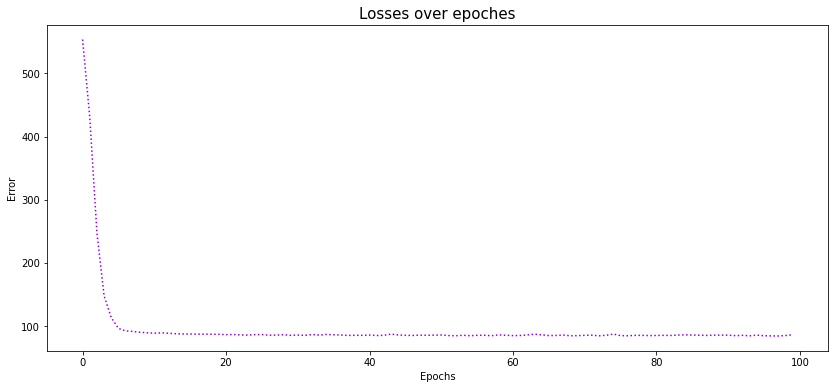

In [60]:
# 전체 loss 에 대한 변화량 시각화
plt.figure(figsize=(14, 6))
plt.plot(losses[:100], c='darkviolet', linestyle=':')

plt.title('Losses over epoches', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()